In [ ]:
/storage/ice1/shared/d-pace_community/makerspace-datasets/MEDICAL/OLIVES

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
from torch.autograd import Variable

data = np.genfromtxt('/content/Biomarker_Clinical_Data_Images.csv', delimiter=',', skip_header=1, usecols=(2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20))

with_headers = np.genfromtxt('/content/Biomarker_Clinical_Data_Images.csv', delimiter=',', names=True, usecols=(2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20))

avgArr = np.zeros([int(data.shape[0]/49), data.shape[1]])

for i in range(0, int(data.shape[0]/49)):
  start = 49*i+1
  scans = data[start:start+48,:]
  avgArr[i] = scans.mean(axis=0)

np.set_printoptions(precision=3, suppress=True)

presence = np.ceil(avgArr)

biomarkerAvg, temp = np.hsplit(avgArr, np.array([16]))
__, scores = np.hsplit(temp, np.array([1]))
biomarkerPresence, __ = np.hsplit(presence, np.array([16]))

avg_train, avg_test, score_train, score_test = train_test_split(biomarkerAvg, scores, train_size = 150, test_size=42, random_state=0)
presence_train, presence_test, __, __ = train_test_split(biomarkerPresence, scores, train_size = 150, test_size=42, random_state=0)

score_train = (score_train - score_train.min(0))/score_train.ptp(0)
score_test = (score_test - score_test.min(0))/score_test.ptp(0)

np.savetxt('presence.csv', presence, delimiter=',')
np.savetxt('average.csv', avgArr, delimiter=',')
np.savetxt('scores.csv', scores, delimiter=',')


In [4]:
torch_avg_train = Variable(torch.from_numpy(avg_train).float())
torch_avg_test = Variable(torch.from_numpy(avg_test).float())
torch_presence_train = Variable(torch.from_numpy(presence_train).float())
torch_presence_test = Variable(torch.from_numpy(presence_test).float())
torch_score_train = Variable(torch.from_numpy(score_train).float())
torch_score_test = Variable(torch.from_numpy(score_test).float())

class FullLinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super(FullLinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(2, 4)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(4, 16)
    def forward(self, x):
        X = self.linear(x)
        X2 = self.relu(X)
        y_pred = self.linear2(X2)
        return y_pred

In [45]:
class SingleLinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super(SingleLinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(2, 4)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(4, 1)
    def forward(self, x):
        X = self.linear(x)
        X2 = self.relu(X)
        y_pred = self.linear2(X2)
        return y_pred

In [6]:
try:
  del avgModel
  del presenceModel
  del loss_fn
  del avg_optimizer
  del presence_optimizer
except:
  pass

presenceModel = FullLinearRegressionModel()
avgModel = FullLinearRegressionModel()
loss_fn = torch.nn.MSELoss()
avg_optimizer = torch.optim.SGD(avgModel.parameters(), lr = 0.01)
presence_optimizer = torch.optim.SGD(presenceModel.parameters(), lr = 0.01)

In [35]:
for epoch in range(5000):

    # Forward pass: Compute predicted y by passing
    # x to the model
    pred_y_presence = presenceModel(torch_score_train)
    pred_y_avg = avgModel(torch_score_train)

    # Compute and print loss
    loss_presence = loss_fn(pred_y_presence, torch_presence_train)
    loss_avg = loss_fn(pred_y_avg, torch_avg_train)

    # Zero gradients, perform a backward pass,
    # and update the weights.
    avg_optimizer.zero_grad()
    presence_optimizer.zero_grad()

    loss_presence.backward()
    loss_avg.backward()

    avg_optimizer.step()
    presence_optimizer.step()

    #if (epoch % 20 == 0):
    #  print('epoch {:04}: loss (average):  {}'.format(epoch, loss_avg.item()))
    #  print('            loss (presence): {}'.format(loss_presence.item()))

test_pred_avg = avgModel(torch_score_test)
test_pred_presence = presenceModel(torch_score_test)
np.set_printoptions(precision=3, suppress=True)
torch.set_printoptions(threshold=10_000)
#print(test_pred_avg)
#print(test_pred_presence)

for i in range(0,16):
  print(f"Presence Loss ({i+1}): {loss_fn(test_pred_presence[:,i], torch_presence_test[:,i])}")
  print(f"Average Loss ({i+1}): {loss_fn(test_pred_avg[:,i], torch_avg_test[:,i])}")



Presence Loss (1): 0.08708145469427109
Average Loss (1): 0.02590986341238022
Presence Loss (2): 0.2064606100320816
Average Loss (2): 0.014674149453639984
Presence Loss (3): 0.02081477642059326
Average Loss (3): 0.0008618745487183332
Presence Loss (4): 0.19993825256824493
Average Loss (4): 0.013574776239693165
Presence Loss (5): 0.0024973535910248756
Average Loss (5): 0.08207203447818756
Presence Loss (6): 0.23947125673294067
Average Loss (6): 0.15007877349853516
Presence Loss (7): 0.2569211721420288
Average Loss (7): 0.2311505824327469
Presence Loss (8): 0.19099578261375427
Average Loss (8): 0.03611687198281288
Presence Loss (9): 0.09262601286172867
Average Loss (9): 0.09250643104314804
Presence Loss (10): 0.024643583223223686
Average Loss (10): 0.00040252404869534075
Presence Loss (11): 0.22105412185192108
Average Loss (11): 0.13596302270889282
Presence Loss (12): 0.12098909914493561
Average Loss (12): 0.14059969782829285
Presence Loss (13): 0.08404812216758728
Average Loss (13): 0.00

Atrophy__thinning_of_retinal_layers (1):
  Presence:
    F1: 0.0
    Loss: 0.095238097012043
  Average:
    Loss: 0.024744760245084763
Disruption_of_EZ (2):
  Presence:
    F1: 0.38461538461538464
    Loss: 0.761904776096344
  Average:
    Loss: 0.015018070116639137
DRIL (3):
  Presence:
    F1: 0.0
    Loss: 0.02380952425301075
  Average:
    Loss: 0.00202389364130795
IR_hemorrhages (4):
  Presence:
    F1: 0.4444444444444444
    Loss: 0.7142857313156128
  Average:
    Loss: 0.016485588625073433
IR_HRF (5):
  Presence:
    F1: 1.0
    Loss: 0.0
  Average:
    Loss: 0.08210813254117966
Partially_attached_vitreous_face (6):
  Presence:
    F1: 0.7647058823529411
    Loss: 0.380952388048172
  Average:
    Loss: 0.14450176060199738
Fully_attached_vitreous_face (7):
  Presence:
    F1: 0.746268656716418
    Loss: 0.4047619104385376
  Average:
    Loss: 0.22292929887771606
Preretinal_tissuehemorrhage (8):
  Presence:
    F1: 0.13333333333333333
    Loss: 0.6190476417541504
  Average:
    Lo

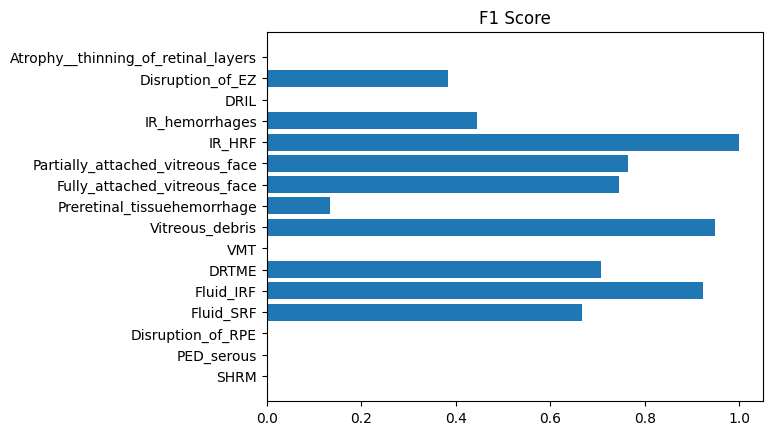

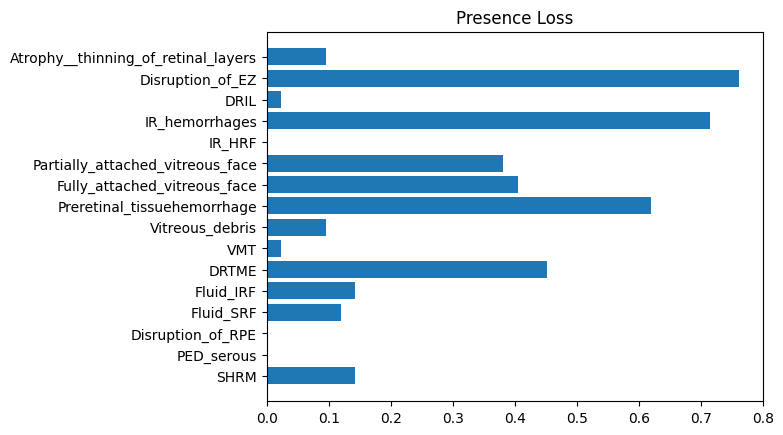

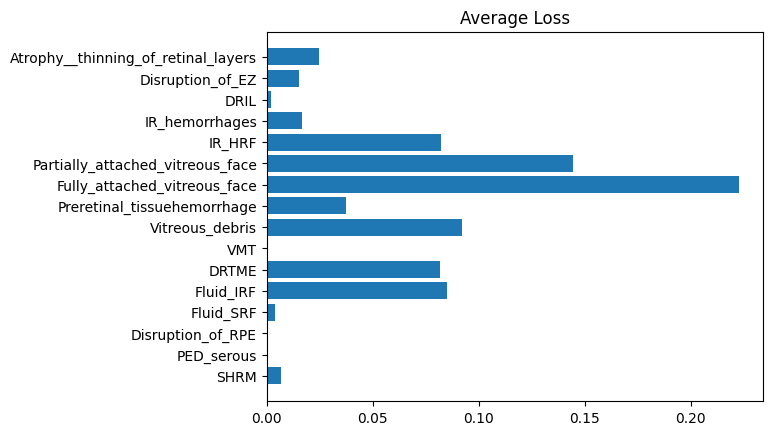

In [47]:
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

del singleModel

biomarkerNames = []
f1_arr = []
pLoss = []
aLoss = []

for i in range(0,16):
  try:
    del singleModel
    del loss_fn
    del optimizer
  except:
    pass

  singlePresence = biomarkerPresence[:,i].reshape(-1,1)
  singleAvg = biomarkerAvg[:,i].reshape(-1,1)

  single_presence_train, single_presence_test, __, __ = train_test_split(singlePresence, scores, train_size = 150, test_size=42, random_state=0)
  single_avg_train, single_avg_test, __, __ = train_test_split(singleAvg, scores, train_size = 150, test_size=42, random_state=0)

  torch_single_presence_train = Variable(torch.from_numpy(single_presence_train).float())
  torch_single_presence_test = Variable(torch.from_numpy(single_presence_test).float())
  torch_single_avg_train = Variable(torch.from_numpy(single_avg_train).float())
  torch_single_avg_test = Variable(torch.from_numpy(single_avg_test).float())

  singleModel = SingleLinearRegressionModel()
  loss_fn = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(singleModel.parameters(), lr = 0.01)
  for epoch in range(1000):
    pred_y = singleModel(torch_score_train)
    loss = loss_fn(pred_y, torch_single_presence_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #if (epoch % 50 == 0):
    #  print('epoch {}, loss {}'.format(epoch, loss.item()))
  pred = singleModel(torch_score_test)
  pred = pred > 0.25
  loss = loss_fn(pred, torch_single_presence_test)
  f1 = f1_score(torch_single_presence_test, pred, average='binary', zero_division=np.nan)

  f1_arr.append(f1)
  pLoss.append(loss.item())
  biomarkerNames.append(with_headers.dtype.names[i])

  print(f"{with_headers.dtype.names[i]} ({i+1}):")
  print("  Presence:")
  print(f"    F1: {f1}")
  print(f"    Loss: {loss.item()}")

  del singleModel
  del loss_fn
  del optimizer
  singleModel = SingleLinearRegressionModel()
  loss_fn = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(singleModel.parameters(), lr = 0.01)

  for epoch in range(1000):
    pred_y = singleModel(torch_score_train)
    loss = loss_fn(pred_y, (torch_single_avg_train))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #if (epoch % 50 == 0):
    #  print('epoch {}, loss {}'.format(epoch, loss.item()))
  pred = singleModel(torch_score_test)
  loss = loss_fn(pred, (torch_single_avg_test))

  aLoss.append(loss.item())

  print("  Average:")
  print(f"    Loss: {loss.item()}")


plt.barh(biomarkerNames, f1_arr)
plt.gca().invert_yaxis()
plt.title('F1 Score')
plt.show()

plt.barh(biomarkerNames, pLoss)
plt.gca().invert_yaxis()
plt.title('Presence Loss')
plt.show()

plt.barh(biomarkerNames, aLoss)
plt.gca().invert_yaxis()
plt.title('Average Loss')
plt.show()

In [ ]:
0.75:

1: 0.0
2: 0.0
3: 0.0
4: 0.0
5: 1.0
6: 0.0
7: 0.2857142857142857
8: 0.0
9: 0.8985507246376812
10: 0.0
11: 0.0
12: 0.782608695652174
13: 0.0
14: nan
15: nan
16: 0.0

0.5:

1: 0.0
2: 0.0
3: 0.0
4: 0.125
5: 1.0
6: 0.6551724137931034
7: 0.746268656716418
8: 0.0
9: 0.935064935064935
10: 0.0
11: 0.68
12: 0.9230769230769231
13: 0.0
14: nan
15: nan
16: 0.0


0.25:

1: 0.0
2: 0.4
3: 0.0
4: 0.4444444444444444
5: 1.0
6: 0.746268656716418
7: 0.746268656716418
8: 0.3333333333333333
9: 0.9367088607594937
10: 0.0
11: 0.7076923076923077
12: 0.9230769230769231
13: 0.625
14: nan
15: 0.0
16: 0.6

0.05:

1: 0.21052631578947367
2: 0.38461538461538464
3: 0.2222222222222222
4: 0.4444444444444444
5: 1.0
6: 0.7647058823529411
7: 0.746268656716418
8: 0.41509433962264153
9: 0.95
10: 0.0
11: 0.7076923076923077
12: 0.9230769230769231
13: 0.10810810810810811
14: 0.0
15: 0.0
16: 0.16216216216216217